In [1]:
import os
from matplotlib.image import imread
import seaborn as sns
sns.set_theme(palette=sns.color_palette('Set2'))
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np

In [2]:
train_folder = 'train_rotated_clustered_edges'
test_folder = 'test_rotated_clustered_edges'

### data analysis

In [3]:
print('number of files in train categories:')
for class_name in ['paper','rock','scissors']:
    print(f'{class_name}: ' + str(len(os.listdir(f'{train_folder}/{class_name}'))))

number of files in train categories:
paper: 612
rock: 626
scissors: 650


In [4]:
print('number of files in test categories:')
for class_name in ['paper','rock','scissors']:
    print(f'{class_name}: ' + str(len(os.listdir(f'{test_folder}/{class_name}'))))

number of files in test categories:
paper: 100
rock: 100
scissors: 100


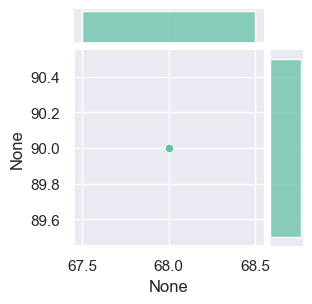

In [5]:
dim1 = []
dim2 = []
for dir1 in [train_folder,test_folder]:
    for dir2 in os.listdir(dir1):
        for img_name in os.listdir(dir1 + '\\' + dir2): 
            img = imread(dir1 + '\\' + dir2 + '\\' + img_name)
            d1,d2 = img.shape
            dim1.append(d1)
            dim2.append(d2)
sns.jointplot(x=dim1,y=dim2,height=3)

### image generator

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
help(ImageDataGenerator)

Help on class ImageDataGenerator in module keras.src.preprocessing.image:

class ImageDataGenerator(builtins.object)
 |  ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, interpolation_order=1, dtype=None)
 |  
 |  Generate batches of tensor image data with real-time data augmentation.
 |  
 |  Deprecated: `tf.keras.preprocessing.image.ImageDataGenerator` is not
 |  recommended for new code. Prefer loading images with
 |  `tf.keras.utils.image_dataset_from_directory` and transforming the output
 |  `tf.data.Dataset` with preprocessing layers. For more infor

In [8]:
image_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.10,
                               height_shift_range=0.10,
                               rescale=1./255,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=False,
                               fill_mode='nearest'
                              )

In [9]:
rock_img = imread(f'{train_folder}\\rock\\' + os.listdir(f'{train_folder}\\rock')[0])

(-0.5, 89.5, 67.5, -0.5)

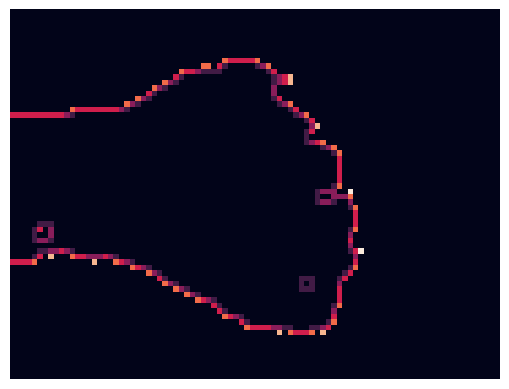

In [10]:
plt.imshow(rock_img)
plt.axis('off')

In [11]:
rock_img = rock_img.reshape(68,90,1)

(-0.5, 89.5, 67.5, -0.5)

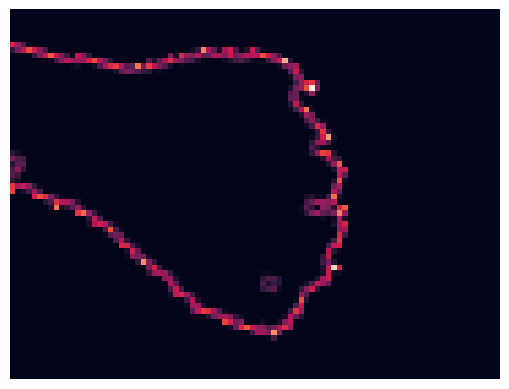

In [12]:
plt.imshow(image_gen.random_transform(rock_img))
plt.axis('off')

In [13]:
image_gen.flow_from_directory(train_folder)

Found 1888 images belonging to 3 classes.


In [14]:
image_gen.flow_from_directory(test_folder)

Found 300 images belonging to 3 classes.


### cnn model

In [15]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models

In [16]:
rock_img.shape

(68, 90, 1)

In [17]:
image_shape = (rock_img.shape[0], rock_img.shape[1], 1)

In [18]:
#https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters
model = models.Sequential()

model.add(layers.Conv2D(filters=128, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))


model.add(layers.Flatten())


model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 66, 88, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2  (None, 33, 44, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 42, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 21, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 19, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 9, 64)          0

### training the model

In [20]:
help(image_gen.flow_from_directory)

Help on method flow_from_directory in module keras.src.preprocessing.image:

flow_from_directory(directory, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None, interpolation='nearest', keep_aspect_ratio=False) method of keras.src.preprocessing.image.ImageDataGenerator instance
    Takes the path to a directory & generates batches of augmented data.
    
    Args:
      directory: string, path to the target directory. It should contain
        one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images
        inside each of the subdirectories directory tree will be included
        in the generator. See [this script](
        https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)
        for more details.
      target_size: Tuple of integers `(height, width)`. The dimensions to
        which all images found will be

In [21]:
batch_size = 16

In [22]:
train_image_gen = image_gen.flow_from_directory(train_folder,
                                                target_size=image_shape[:2],
                                                color_mode='grayscale',
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 1888 images belonging to 3 classes.


In [23]:
test_image_gen = image_gen.flow_from_directory(test_folder,
                                               target_size=image_shape[:2],
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='categorical',shuffle=False)

Found 300 images belonging to 3 classes.


(-0.5, 89.5, 67.5, -0.5)

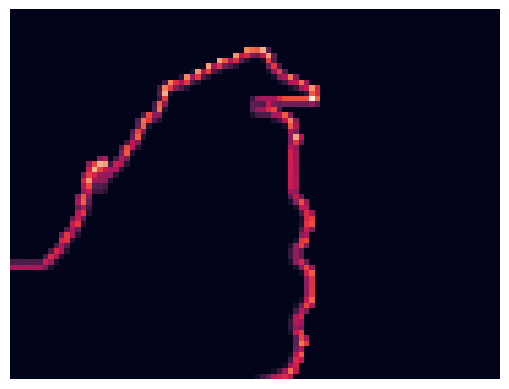

In [24]:
plt.imshow(train_image_gen.next()[0][0])
plt.axis('off')

(-0.5, 89.5, 67.5, -0.5)

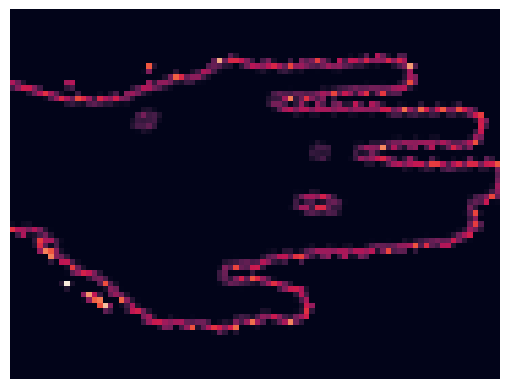

In [25]:
plt.imshow(test_image_gen.next()[0][0])
plt.axis('off')

In [26]:
train_image_gen.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint_callback = ModelCheckpoint(
    filepath='models\\temp\\',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [29]:
start = time.time()

results = model.fit(train_image_gen,
                    epochs=20,
                    validation_data=test_image_gen,
                    callbacks=[model_checkpoint_callback],
                    )

stop = time.time()
print('\n',(stop-start)//60,'min.')

Epoch 1/20


118/118 [==============================] - ETA: 0s - loss: 0.7681 - accuracy: 0.6425INFO:tensorflow:Assets written to: models\temp\assets


INFO:tensorflow:Assets written to: models\temp\assets


118/118 [==============================] - 10s 72ms/step - loss: 0.7681 - accuracy: 0.6425 - val_loss: 0.4150 - val_accuracy: 0.8533
Epoch 2/20
118/118 [==============================] - ETA: 0s - loss: 0.4320 - accuracy: 0.8427INFO:tensorflow:Assets written to: models\temp\assets


INFO:tensorflow:Assets written to: models\temp\assets


118/118 [==============================] - 8s 67ms/step - loss: 0.4320 - accuracy: 0.8427 - val_loss: 0.2926 - val_accuracy: 0.9000
Epoch 3/20
118/118 [==============================] - ETA: 0s - loss: 0.3243 - accuracy: 0.8909INFO:tensorflow:Assets written to: models\temp\assets


INFO:tensorflow:Assets written to: models\temp\assets


118/118 [==============================] - 8s 70ms/step - loss: 0.3243 - accuracy: 0.8909 - val_loss: 0.2359 - val_accuracy: 0.9233
Epoch 4/20
118/118 [==============================] - 7s 58ms/step - loss: 0.2475 - accuracy: 0.9200 - val_loss: 0.3559 - val_accuracy: 0.8733
Epoch 5/20
118/118 [==============================] - 7s 58ms/step - loss: 0.2301 - accuracy: 0.9237 - val_loss: 0.2175 - val_accuracy: 0.9167
Epoch 6/20
118/118 [==============================] - ETA: 0s - loss: 0.2099 - accuracy: 0.9311INFO:tensorflow:Assets written to: models\temp\assets


INFO:tensorflow:Assets written to: models\temp\assets


118/118 [==============================] - 8s 67ms/step - loss: 0.2099 - accuracy: 0.9311 - val_loss: 0.1478 - val_accuracy: 0.9433
Epoch 7/20
118/118 [==============================] - 7s 59ms/step - loss: 0.1553 - accuracy: 0.9497 - val_loss: 0.1529 - val_accuracy: 0.9400
Epoch 8/20
118/118 [==============================] - ETA: 0s - loss: 0.1624 - accuracy: 0.9460INFO:tensorflow:Assets written to: models\temp\assets


INFO:tensorflow:Assets written to: models\temp\assets


118/118 [==============================] - 8s 68ms/step - loss: 0.1624 - accuracy: 0.9460 - val_loss: 0.1200 - val_accuracy: 0.9500
Epoch 9/20
118/118 [==============================] - 7s 58ms/step - loss: 0.1430 - accuracy: 0.9507 - val_loss: 0.1313 - val_accuracy: 0.9400
Epoch 10/20
118/118 [==============================] - 7s 58ms/step - loss: 0.1482 - accuracy: 0.9502 - val_loss: 0.1390 - val_accuracy: 0.9333
Epoch 11/20
118/118 [==============================] - 7s 59ms/step - loss: 0.1638 - accuracy: 0.9502 - val_loss: 0.1922 - val_accuracy: 0.9367
Epoch 12/20
118/118 [==============================] - ETA: 0s - loss: 0.1172 - accuracy: 0.9656INFO:tensorflow:Assets written to: models\temp\assets


INFO:tensorflow:Assets written to: models\temp\assets


118/118 [==============================] - 8s 67ms/step - loss: 0.1172 - accuracy: 0.9656 - val_loss: 0.1277 - val_accuracy: 0.9567
Epoch 13/20
118/118 [==============================] - ETA: 0s - loss: 0.0972 - accuracy: 0.9672INFO:tensorflow:Assets written to: models\temp\assets


INFO:tensorflow:Assets written to: models\temp\assets


118/118 [==============================] - 8s 67ms/step - loss: 0.0972 - accuracy: 0.9672 - val_loss: 0.0519 - val_accuracy: 0.9867
Epoch 14/20
118/118 [==============================] - 7s 58ms/step - loss: 0.1030 - accuracy: 0.9698 - val_loss: 0.0868 - val_accuracy: 0.9767
Epoch 15/20
118/118 [==============================] - 7s 60ms/step - loss: 0.0980 - accuracy: 0.9709 - val_loss: 0.0932 - val_accuracy: 0.9733
Epoch 16/20
118/118 [==============================] - 7s 59ms/step - loss: 0.0996 - accuracy: 0.9698 - val_loss: 0.0642 - val_accuracy: 0.9767
Epoch 17/20
118/118 [==============================] - 7s 59ms/step - loss: 0.1031 - accuracy: 0.9682 - val_loss: 0.1015 - val_accuracy: 0.9667
Epoch 18/20
118/118 [==============================] - 7s 59ms/step - loss: 0.0864 - accuracy: 0.9709 - val_loss: 0.0606 - val_accuracy: 0.9767
Epoch 19/20
118/118 [==============================] - 7s 59ms/step - loss: 0.0914 - accuracy: 0.9672 - val_loss: 0.0989 - val_accuracy: 0.9700
Epoc

In [30]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y-%m-%d--%H-%M")
model.save('models\\' + timestamp)

INFO:tensorflow:Assets written to: models\2024-04-09--18-41\assets


INFO:tensorflow:Assets written to: models\2024-04-09--18-41\assets


### model evaluation

In [31]:
losses = pd.DataFrame(model.history.history)

<Axes: >

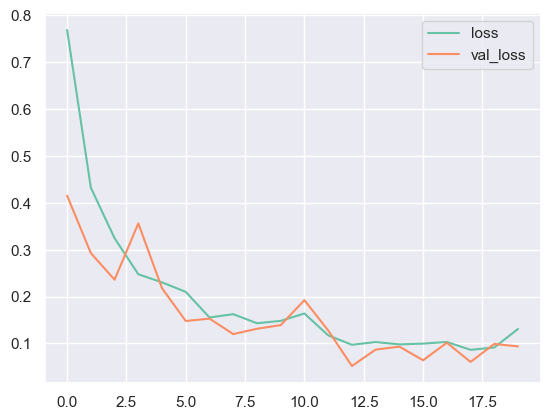

In [32]:
losses[['loss','val_loss']].plot()

<Axes: >

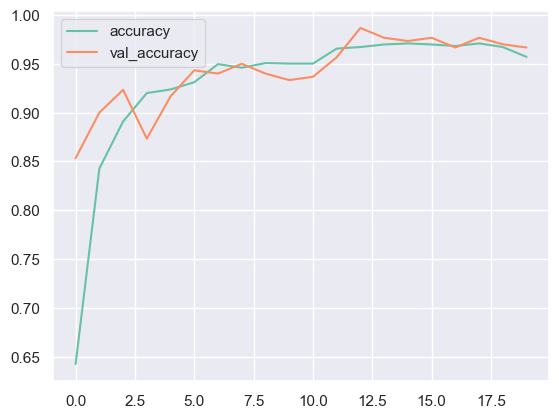

In [33]:
losses[['accuracy','val_accuracy']].plot()

In [34]:
model.metrics_names

['loss', 'accuracy']

In [35]:
model.evaluate(test_image_gen)

19/19 [==============================] - 1s 23ms/step - loss: 0.0475 - accuracy: 0.9833


[0.047505371272563934, 0.9833333492279053]

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [37]:
predictions = np.argmax(model.predict(test_image_gen), axis=-1)

19/19 [==============================] - 1s 23ms/step


In [38]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       100
           1       0.98      0.97      0.97       100
           2       0.98      0.96      0.97       100

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



In [39]:
cm = confusion_matrix(test_image_gen.classes,predictions)
cm

array([[96,  2,  2],
       [ 3, 97,  0],
       [ 4,  0, 96]], dtype=int64)

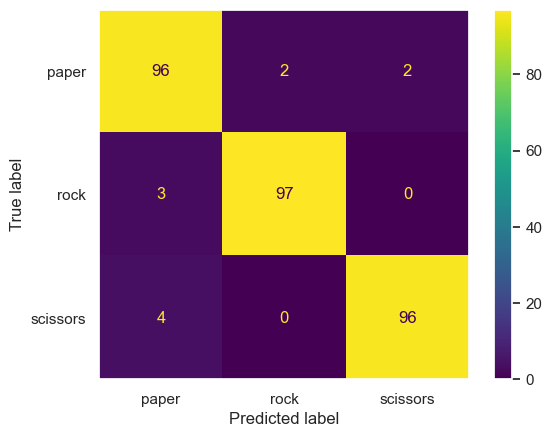

In [40]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=test_image_gen.class_indices)
disp.plot()
plt.grid(False)
plt.show()